This notebook illustrates a few practical methods of working with class-unbalanced data while trying to solve for a classification problem. The dataset used in this notebook is the publicly available <a href="https://www.kaggle.com/c/titanic">Titanic Survivors dataset</a> from Kaggle and is used for illustrative purposes only.

The methods and techniques presented are not intended to be instructive or conclusive, but simply techniques to be considered individually or in-combination with each other, based on my learning and experience. The accompanying blog post to this notebook goes into narrative detail about the techniques covered in this notebook.

In [1]:
import pandas as pd
import imblearn as im
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Load and explore sample data

In [2]:
train_data = pd.read_csv('train.csv')
print(train_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
print(train_data.shape)

(891, 12)


In [4]:
print(train_data.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [5]:
print(train_data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Check to see the amount of observations per class

In [6]:
print(train_data['Survived'].value_counts())

0    549
1    342
Name: Survived, dtype: int64


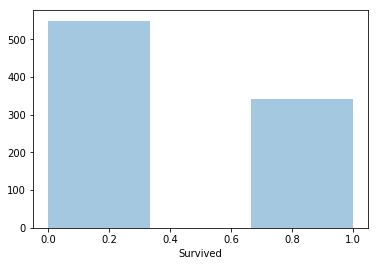

In [7]:
sns.distplot(train_data['Survived'], kde=False, hist=True, bins=3)

In [8]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Nulls will need to be handled and categorical types will need to be transformed

## Data Cleansing

Taking the average age and adding to the missing

In [9]:
train_data['Age'] = train_data['Age'].fillna(30)

Too many missing values in "Cabin" to impute. For simplicity's sake going to just drop it

In [10]:
train_data = train_data.drop(columns=["Cabin"])

Check on two missing values for "Embarked"

In [11]:
train_data[train_data.isnull().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [12]:
gender, gender_uniques = pd.factorize(train_data['Sex'])

In [13]:
train_data['Sex'] = gender

In [14]:
embarked, embarked_uniques = pd.factorize(train_data['Embarked'])

In [15]:
train_data['Embarked'] = embarked

In [16]:
train_data.shape

(891, 11)

In [17]:
print(train_data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked         int64
dtype: object


Drop columns not needed for training and create array for labels

In [18]:
train_data = train_data[['Survived', 'PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

## Convenience methods for data splitting, model training, and metrics

In [19]:
def prepandsplitdata(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test

In [20]:
def trainmodel(X_train, y_train):
    logresult = LogisticRegression(penalty='l2', 
                                   dual=False, solver='liblinear', 
                                   class_weight='balanced', random_state=1).fit(X_train, y_train)
    return logresult

In [21]:
def getmetrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    f1score = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    return f1score, cm

## Downsampling

Downsampling approach using resample()

In [22]:
major_class = train_data[train_data['Survived']==0]
minor_class = train_data[train_data['Survived']==1]

In [23]:
#resample the major class to a subset equal to the number of samples in the minority class
downsample_major = resample(major_class, replace=False, n_samples=342)

In [24]:
balanced_train_data = pd.concat([downsample_major, minor_class])

In [25]:
y = balanced_train_data['Survived']
X = balanced_train_data[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp','Parch','Fare','Embarked']]

In [26]:
X_train, X_test, y_train, y_test = prepandsplitdata(X, y)

In [27]:
downsample_model = trainmodel(X_train, y_train)

In [28]:
downsample_f1, downsample_cm = getmetrics(downsample_model, X_test, y_test)

In [29]:
print(downsample_f1)

0.7643979057591622


In [30]:
print(downsample_cm)

[[88 15]
 [30 73]]


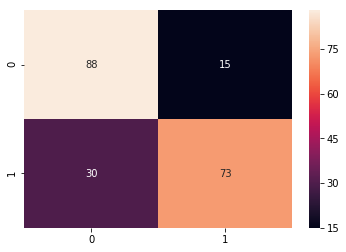

In [31]:
sns.heatmap(downsample_cm, annot=True, fmt="d")

In [32]:
y = train_data['Survived']
X = train_data[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp','Parch','Fare','Embarked']]

## SMOTE 

In [33]:
X_smote, y_smote = SMOTENC(categorical_features=[2,7]).fit_resample(X.values, y.values)

In [34]:
X_train, X_test, y_train, y_test = prepandsplitdata(X_smote, y_smote)

In [35]:
smote_model = trainmodel(X_train, y_train)

In [36]:
smote_f1, smote_cm = getmetrics(smote_model, X_test, y_test)

In [37]:
print(smote_f1)

0.7767584097859327


In [38]:
print(smote_cm)

[[130  35]
 [ 38 127]]


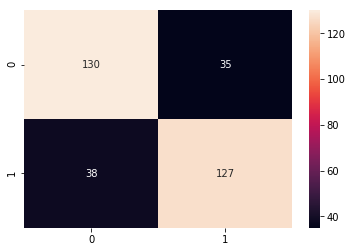

In [39]:
sns.heatmap(smote_cm, annot=True, fmt="d")

## ADASYN 

In [40]:
X_adasyn, y_adasyn = ADASYN().fit_resample(X.values, y.values)

In [41]:
X_train, X_test, y_train, y_test = prepandsplitdata(X_adasyn, y_adasyn)

In [42]:
adasyn_model = trainmodel(X_train, y_train)

In [43]:
adasyn_f1, adasyn_cm = getmetrics(adasyn_model, X_test, y_test)

In [44]:
print(adasyn_f1)

0.775


In [45]:
print(adasyn_cm)

[[132  33]
 [ 39 124]]


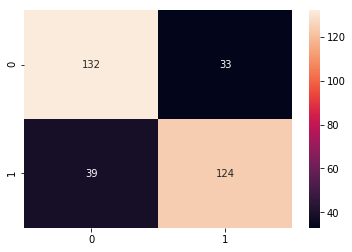

In [46]:
sns.heatmap(adasyn_cm, annot=True, fmt="d")